In [1]:
pwd

'C:\\Users\\Maria\\ML'

In [1]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt
Pavia = sio.loadmat('PaviaU_cube.mat')
HSI = Pavia['X'] 

ends = sio.loadmat('PaviaU_endmembers.mat') 
endmembers = ends['endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('9 Endmembers spectral signatures of Pavia University HSI')
plt.show()

ground_truth= sio.loadmat('PaviaU_ground_truth.mat')
labels=ground_truth['y']

fig = plt.figure()
plt.imshow(HSI[:,:,50])
plt.title('RGB Visualization of the 10th band of Pavia University HSI')
plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

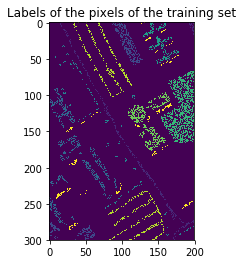

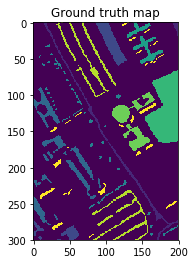

In [2]:
# Trainining set for classification 
Pavia_labels = sio.loadmat('classification_labels_Pavia.mat')
Training_Set = (np.reshape(Pavia_labels['training_set'],(200,300))).T
Test_Set = (np.reshape(Pavia_labels['test_set'],(200,300))).T

Operational_Set = (np.reshape(Pavia_labels['operational_set'],(200,300))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()


fig = plt.figure()
plt.imshow(labels)
plt.title('Ground truth map')
plt.show()

## Dimensions

Some information about the matrices dimensions. The matrix of the labels can be characterized as sparsed (sparsity> 0.5)

In [3]:
print("The hypercube university's shape is:", HSI.shape)
print("----------")
print("The endmembers shape is:", endmembers.shape)
print("----------")
print("The labels' shape is:",labels.shape)
print("The unique class labels are:",np.unique(labels))
print("----------")
print("There are",np.count_nonzero(labels),"non-zero labels, out of",labels.shape[0]*labels.shape[1])
print("The sparsity of the matrix is:",round((labels.shape[0]*labels.shape[1]-np.count_nonzero(labels))/(labels.shape[0]*labels.shape[1]),3))
print("----------")

The hypercube university's shape is: (300, 200, 103)
----------
The endmembers shape is: (103, 9)
----------
The labels' shape is: (300, 200)
The unique class labels are: [0 1 2 3 4 5 6 7 8 9]
----------
There are 12829 non-zero labels, out of 60000
The sparsity of the matrix is: 0.786
----------


In [4]:
def plot_endmembers(data,title):
    
    '''
    Creates maps with endmembers after the estimation of thetas for each method
    
    '''
    fig = plt.figure(figsize=(10,10))
    materials=['Water','Trees','Asphalt','Self-Blocking Bricks','Bitumen','Tiles','Shadows','Meadows','Bare Soil']

    for i in range(len(materials)):
        
        ax=fig.add_subplot(3,3,i+1)
        ax.set_title('{}'.format(materials[i]))
        ax.imshow(data[:,:,i])

    fig.suptitle(title)
    plt.show()

In [5]:
m= 300
n = 200

def recon_error(est):
    error = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            if((est[i,j,0] == 0) & (est[i,j,1] == 0) & (est[i,j,2] == 0) & (est[i,j,3] == 0) & (est[i,j,4] == 0) & (est[i,j,5] == 0) & (est[i,j,6] == 0) & (est[i,j,7] == 0) & (est[i,j,8] == 0)):
                
                continue
            error[i,j] =(np.linalg.norm(HSI[i,j,:] - np.dot(endmembers, est[i,j,:])))**2
    return error

## Part 1 ( Spectral Unmixing)


### (a) Least Squares (unconstrained)


The error for Least Squares is: 118783.181


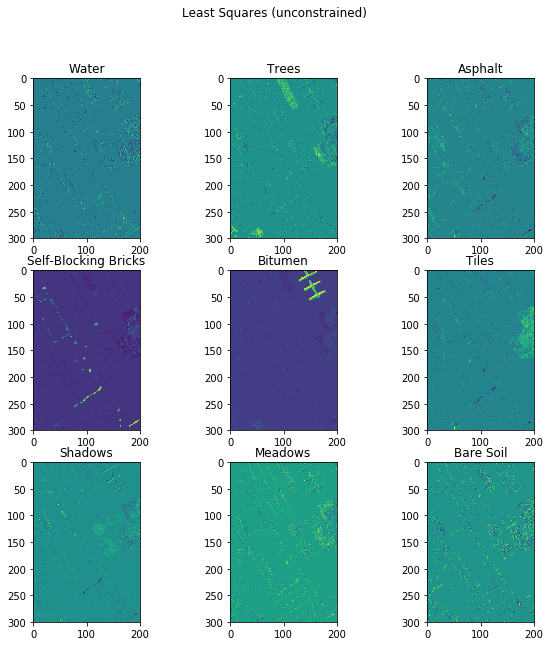

In [6]:
theta_est = np.zeros((m,n,9))

for i in range(m):
    
    for j in range(n):
        if labels[i,j] == 0:
            continue
        XTX_inv = np.linalg.inv(np.dot(endmembers.T,endmembers))

        #LS estimator
        theta_est[i,j,:] = (XTX_inv).dot(endmembers.T).dot(HSI[i,j,:])
re_a = (np.true_divide(recon_error(theta_est).sum(),(recon_error(theta_est)!=0).sum()))
print()
print("The error for Least Squares is:",round(re_a,3))
plot_endmembers(theta_est,"Least Squares (unconstrained)")

### (b) Least Squares with constraint sum to one

In [7]:
#!pip install cvxpy

In [8]:
# Use CVXPY (wrapper)
import cvxpy as cp

thetas_sum_to_one = np.zeros((m,n,9,1))
#theta_est=[]
for i in range(m):
    
    for j in range(n):
        
        if(labels[i,j] ==0):
            continue
        X = endmembers
        Y = HSI[i,j,:]

        # Construct the problem.
        thetaa = cp.Variable(9)
        objective = cp.Minimize(cp.sum_squares(X*thetaa - Y))
        constraints = [thetaa <= 1]
        prob = cp.Problem(objective, constraints)
        
        # The optimal objective value is returned by `prob.solve()`.
        result = prob.solve('SCS')
        theta_est=[]
        theta_est.append(thetaa.value)
        thetas_sum_to_one[i,j] = np.array(theta_est)

The error for Least Squares (sum to one) is: 144662.747


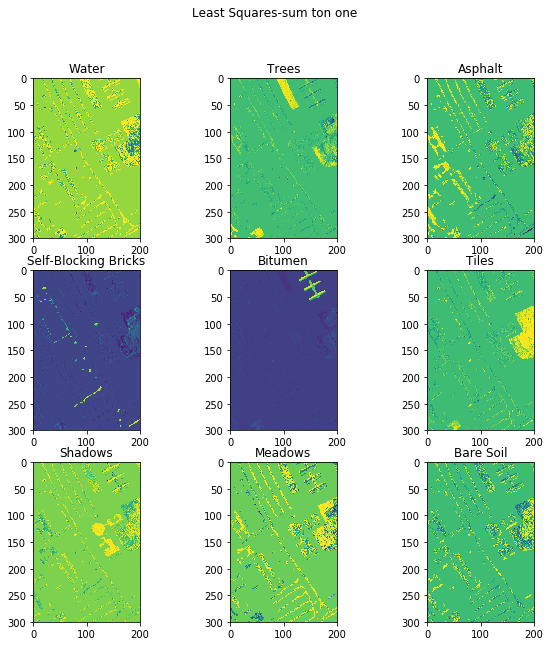

In [9]:
thetas_sum_to_one = thetas_sum_to_one.reshape(300,200,9)
re_b = (np.true_divide(recon_error(thetas_sum_to_one).sum(),(recon_error(thetas_sum_to_one)!=0).sum()))
print("The error for Least Squares (sum to one) is:",round(re_b,3))
plot_endmembers(thetas_sum_to_one,"Least Squares-sum ton one")

In [10]:
# use CVXOPT
'''from cvxopt.solvers import qp
from cvxopt import solvers,matrix
solvers.options['show_progress'] = False

sum_to_one = np.zeros((m, n, 9))

for i in range(m):
    
    for j in range(n):
        
        if(labels[i,j] ==0):
            continue
            
        P = endmembers.T.dot(endmembers)
        P = matrix(P)
    
               
        q = HSI[i,j,:].T.reshape(1,103).dot(endmembers)
        q = matrix(q)
        
        
        A = np.ones((1,9))
        A = matrix(A)
        
        b = np.ones(1)
        b = matrix(b)  
        
        results = qp(P, q.T, G=None, h=None, A =  A, b = b)['x']
        theta_est=np.stack(results, axis=0)
        #theta_est=[]
        #theta_est.append(results)
        sum_to_one[i,j] = np.array(theta_est)
print()
re_b = (np.true_divide(recon_error(sum_to_one.reshape(300,200,9)).sum(),(recon_error(sum_to_one.reshape(300,200,9))!=0).sum()))
print("The error for Least Squares (sum to one) is:",round(re_b,3))
plot_endmembers(sum_to_one.reshape(300,200,9),"Least Squares-sum ton one")'''

'from cvxopt.solvers import qp\nfrom cvxopt import solvers,matrix\nsolvers.options[\'show_progress\'] = False\n\nsum_to_one = np.zeros((m, n, 9))\n\nfor i in range(m):\n    \n    for j in range(n):\n        \n        if(labels[i,j] ==0):\n            continue\n            \n        P = endmembers.T.dot(endmembers)\n        P = matrix(P)\n    \n               \n        q = HSI[i,j,:].T.reshape(1,103).dot(endmembers)\n        q = matrix(q)\n        \n        \n        A = np.ones((1,9))\n        A = matrix(A)\n        \n        b = np.ones(1)\n        b = matrix(b)  \n        \n        results = qp(P, q.T, G=None, h=None, A =  A, b = b)[\'x\']\n        theta_est=np.stack(results, axis=0)\n        #theta_est=[]\n        #theta_est.append(results)\n        sum_to_one[i,j] = np.array(theta_est)\nprint()\nre_b = (np.true_divide(recon_error(sum_to_one.reshape(300,200,9)).sum(),(recon_error(sum_to_one.reshape(300,200,9))!=0).sum()))\nprint("The error for Least Squares (sum to one) is:",round(r

### (c) Non Negative Least Square 


The error for Least Squares (non-negative) is: 569339.291


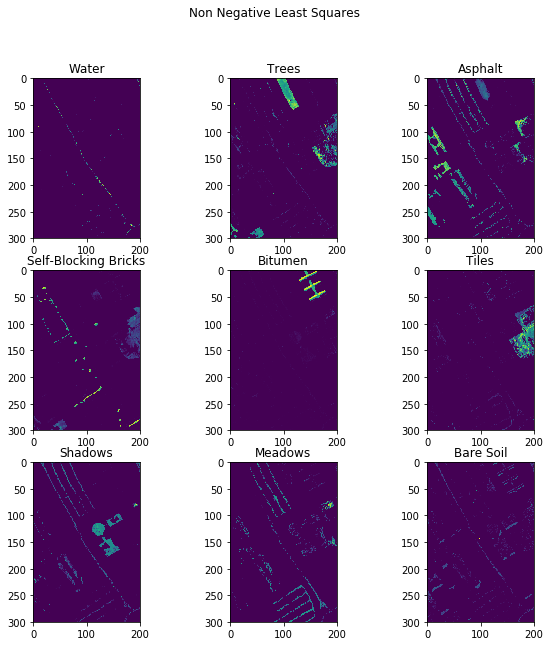

In [11]:
from scipy.optimize import nnls

theta_nnl = np.zeros((m,n,9))

for i in range(m):
    
    for j in range(n):
        if labels[i,j]==0:
            continue
        
        theta_nnl[i,j,:]  = nnls(endmembers, HSI[i,j,:])[0]
print()
re_c = (np.true_divide(recon_error(theta_nnl).sum(),(recon_error(theta_nnl)!=0).sum()))
print("The error for Least Squares (non-negative) is:",round(re_c,3))
plot_endmembers(theta_nnl,"Non Negative Least Squares")

### (d) Non Negative Least Square and sum to one

In [12]:
thetas_all = np.zeros((m,n,9,1))

for i in range(m):
    
    for j in range(n):
        
        if(labels[i,j] ==0):
            continue
        X = endmembers
        Y = HSI[i,j,:]

        # Construct the problem.
        thetaa = cp.Variable(9)
        objective = cp.Minimize(cp.sum_squares(X*thetaa - Y))
        constraints = [0 <= thetaa, thetaa <= 1]
        prob = cp.Problem(objective, constraints)
        
        # The optimal objective value is returned by `prob.solve()`.
        result = prob.solve('SCS')       
        theta_est=[]
        theta_est.append(thetaa.value)
        thetas_all[i,j] = np.array(theta_est)

The error for Least Squares (sum to one and non negative) is: 219895.228


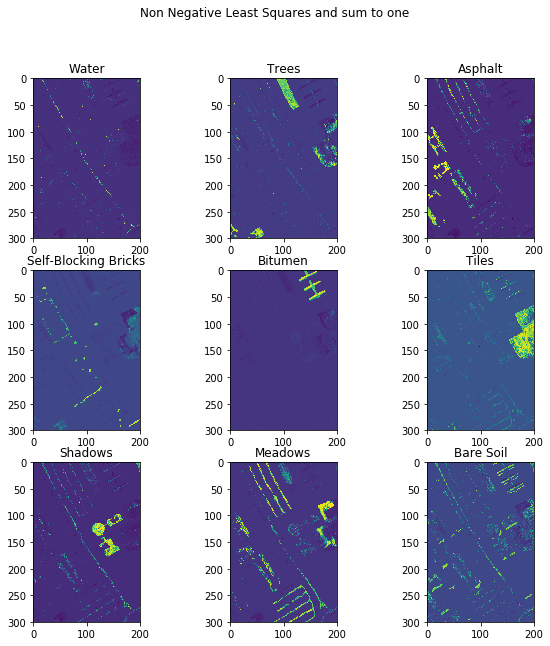

In [13]:
thetas_all = thetas_all.reshape(300,200,9)
re_d = (np.true_divide(recon_error(thetas_all).sum(),(recon_error(thetas_all)!=0).sum()))
print("The error for Least Squares (sum to one and non negative) is:",round(re_d,3))
plot_endmembers(thetas_all,"Non Negative Least Squares and sum to one")

In [14]:
'''from cvxopt.solvers import qp
from cvxopt import solvers,matrix
solvers.options['show_progress'] = False

thetas_all = np.zeros((m, n, 9))

for i in range(m):
    
    for j in range(n):
        
        if labels[i,j] == 0:
            continue
            
        P = endmembers.T.dot(endmembers)
        P = matrix(P)

        G = -np.eye(9,9)
        G = matrix(G)

        h = np.zeros((9,1))
        h = matrix(h)

        A = np.ones((1,9))
        A = matrix(A)

        b = np.ones(1)
        b = matrix(b)

        q = HSI[i,j,:].reshape(1,103).dot(endmembers).T
        q = matrix(q)
        
        results = qp(P,q,G,h,A,b)['x']
        #if labels[i,j] != 0:
            #print(results)
        theta_est=np.stack(results, axis=0)
        thetas_all[i,j] = np.array(theta_est)
print()
re_d = (np.true_divide(recon_error(thetas_all).sum(),(recon_error(thetas_all)!=0).sum()))
print("The error for Least Squares (sum to one and non negative) is:",round(re_d,3))
plot_endmembers(thetas_all,"Non Negative Least Squares and sum to one")'''

'from cvxopt.solvers import qp\nfrom cvxopt import solvers,matrix\nsolvers.options[\'show_progress\'] = False\n\nthetas_all = np.zeros((m, n, 9))\n\nfor i in range(m):\n    \n    for j in range(n):\n        \n        if labels[i,j] == 0:\n            continue\n            \n        P = endmembers.T.dot(endmembers)\n        P = matrix(P)\n\n        G = -np.eye(9,9)\n        G = matrix(G)\n\n        h = np.zeros((9,1))\n        h = matrix(h)\n\n        A = np.ones((1,9))\n        A = matrix(A)\n\n        b = np.ones(1)\n        b = matrix(b)\n\n        q = HSI[i,j,:].reshape(1,103).dot(endmembers).T\n        q = matrix(q)\n        \n        results = qp(P,q,G,h,A,b)[\'x\']\n        #if labels[i,j] != 0:\n            #print(results)\n        theta_est=np.stack(results, axis=0)\n        thetas_all[i,j] = np.array(theta_est)\nprint()\nre_d = (np.true_divide(recon_error(thetas_all).sum(),(recon_error(thetas_all)!=0).sum()))\nprint("The error for Least Squares (sum to one and non negative) is

### (e) Lasso

#### Cross Validation to define alpha fro Lasso

In [15]:
'''from sklearn.linear_model import LassoCV
import warnings

warnings.filterwarnings('ignore')
 
#alphas = [1e-3, 1e-1, 1, 1e2, 1e3, 1e4, 1e5]
alphas = [1e3, 2000,2100, 2190,2200, 2500]

model_cv = LassoCV(n_alphas=100, alphas=alphas,cv=5, random_state = 0)

alpha_lasso = np.zeros((m,n,9))

for i in range(m):
    
    for j in range(n):
        
        model_cv.fit(endmembers,HSI[i,j,:])
        alpha_lasso[i,j,:] =  model_cv.alpha_
# Find the mode value of alpha
from scipy import stats
print(stats.mode(alpha_lasso.reshape(540000,1)))
plt.hist(alpha_lasso.reshape(540000,1))'''



"from sklearn.linear_model import LassoCV\nimport warnings\n\nwarnings.filterwarnings('ignore')\n \n#alphas = [1e-3, 1e-1, 1, 1e2, 1e3, 1e4, 1e5]\nalphas = [1e3, 2000,2100, 2190,2200, 2500]\n\nmodel_cv = LassoCV(n_alphas=100, alphas=alphas,cv=5, random_state = 0)\n\nalpha_lasso = np.zeros((m,n,9))\n\nfor i in range(m):\n    \n    for j in range(n):\n        \n        model_cv.fit(endmembers,HSI[i,j,:])\n        alpha_lasso[i,j,:] =  model_cv.alpha_\n# Find the mode value of alpha\nfrom scipy import stats\nprint(stats.mode(alpha_lasso.reshape(540000,1)))\nplt.hist(alpha_lasso.reshape(540000,1))"


The error for Lasso is: 40299459.94


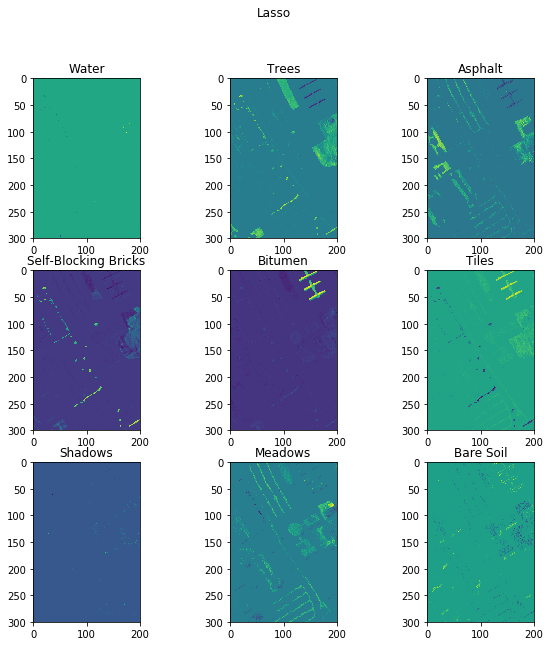

In [16]:
from sklearn.linear_model import Lasso
import warnings

warnings.filterwarnings('ignore')

theta_lasso = np.zeros((m,n,9))
model = Lasso(alpha=1000,max_iter=100,random_state=0)

for i in range(m):
    
    for j in range(n):
        if labels[i,j] == 0:
            continue
        model.fit(endmembers,HSI[i,j,:])
        theta_lasso[i,j,:] =  model.coef_
print()
re_e = (np.true_divide(recon_error(theta_lasso).sum(),(recon_error(theta_lasso)!=0).sum()))
print("The error for Lasso is:",round(re_e,3))
plot_endmembers(theta_lasso,"Lasso")

In [17]:
# sparse solution: zero-valued elements/ sum of elements ( >0.5 means sparse)
((m*n*9)-np.count_nonzero(theta_lasso))/(m*n*9)

0.8860814814814815

## Part 2 (Supervised Classification)

## Prepare data

In [55]:
data = HSI.reshape(60000,103)

Training_Set = (np.reshape(Pavia_labels['training_set'],(200,300))).T
Test_Set = (np.reshape(Pavia_labels['test_set'],(200,300))).T
print("Classification task")
print(".............................................")
print("The non zero values of training set are:",np.count_nonzero(Training_Set))
print("The non zero values of test set are:",np.count_nonzero(Test_Set))
# Train
zeros_index_train =np.where(Training_Set.ravel() == 0)[0]
training_set = np.delete(Training_Set.ravel(), zeros_index_train, axis=0)
dataNew_train = np.delete(data, zeros_index_train, axis=0)
# test
zeros_index_test = np.where(Test_Set.ravel() == 0)[0]
test_set = np.delete(Test_Set.ravel(), zeros_index_test, axis=0)
dataNew_test = np.delete(data, zeros_index_test, axis=0)

X_train = dataNew_train
y_train = training_set
X_test = dataNew_test
y_test = test_set

Classification task
.............................................
The non zero values of training set are: 6415
The non zero values of test set are: 3207


In [19]:
from sklearn.model_selection import cross_val_score
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        print(" ")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [20]:
def print_classification_metrics(y_true,y_predicted):
    
    '''
    This method prints classification the metrics: f1-score, accuracy, recall, precision 
    and classification report.    
    '''
    from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score,classification_report

    
    score = f1_score(y_true, y_predicted, average='micro')
    accuracy = accuracy_score(y_true, y_predicted)
    print()
    print("test accuracy_score:",round(accuracy,4))
    print()
    print("test f1-score:",round(score,4))
    print()
    recall = recall_score(y_true, y_predicted, average='micro')
    precision = precision_score(y_true, y_predicted, average='micro')
    print("test precision score",round(precision,4))
    print()
    print("test recall score",round(recall,4))
    print()
    print(classification_report(y_true,y_predicted))

## Principal Component Analysis

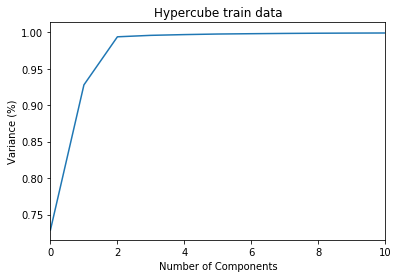

In [21]:
from sklearn.decomposition import PCA

#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_train)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,10)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Hypercube train data')
plt.show()

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

## Create Baseline - Dummy Classifier

test f1-score: 0.1328

test precision score 0.1328

test recall score 0.1328
Normalized confusion matrix
 
[[0.08 0.11 0.14 0.04 0.07 0.25 0.13 0.12 0.08]
 [0.08 0.12 0.12 0.04 0.09 0.25 0.1  0.12 0.07]
 [0.1  0.12 0.15 0.04 0.08 0.22 0.09 0.15 0.05]
 [0.06 0.11 0.13 0.05 0.07 0.24 0.1  0.17 0.06]
 [0.05 0.13 0.17 0.05 0.07 0.24 0.09 0.11 0.08]
 [0.1  0.11 0.14 0.04 0.06 0.23 0.12 0.14 0.05]
 [0.1  0.09 0.17 0.03 0.04 0.23 0.1  0.16 0.08]
 [0.1  0.12 0.19 0.05 0.05 0.21 0.12 0.1  0.06]
 [0.09 0.09 0.16 0.05 0.06 0.23 0.11 0.18 0.05]]


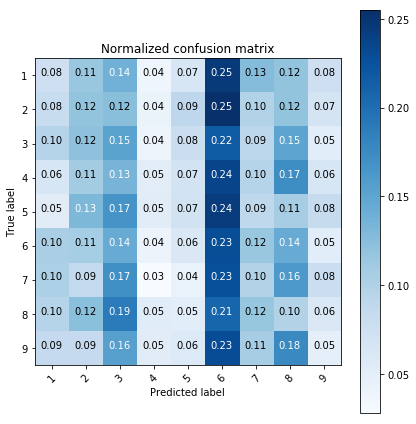

In [23]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score

base = DummyClassifier()
base.fit(X_train, y_train)

predictions_test = base.predict(X_test)
score = f1_score(y_test, predictions_test, average='micro')
print("test f1-score:",round(score,4))
print()

recall = recall_score(y_test, predictions_test, average='micro')
precision = precision_score(y_test, predictions_test, average='micro')
print("test precision score",round(precision,4))
print()
print("test recall score",round(recall,4))

class_names = [ 1, 2, 3, 4, 5, 6, 7, 8, 9]


cnf_matrix = confusion_matrix(y_test, predictions_test)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

## Train and predict

### (a) Naive Bayes Classifier 
1. (PCA-10 components) -- (OPTIONAL)

The mean f1-micro score with a 10-fold Cross Validation is: 0.816
The standard deviation of f1-micro score with a 10-fold Cross Validation is: 0.056
---------------------------------------------------------------------------
Normalized confusion matrix
 
[[0.66 0.   0.03 0.   0.   0.   0.2  0.11 0.  ]
 [0.   0.89 0.   0.01 0.   0.1  0.   0.   0.  ]
 [0.1  0.01 0.58 0.   0.   0.01 0.01 0.29 0.  ]
 [0.   0.   0.   0.97 0.   0.03 0.   0.   0.  ]
 [0.   0.   0.   0.   0.99 0.01 0.   0.   0.  ]
 [0.   0.13 0.   0.   0.   0.86 0.   0.   0.  ]
 [0.17 0.   0.01 0.   0.   0.   0.81 0.   0.  ]
 [0.03 0.   0.16 0.   0.   0.01 0.   0.79 0.  ]
 [0.   0.   0.   0.   0.01 0.   0.   0.   0.99]]

test accuracy_score: 0.8067

test f1-score: 0.8067

test precision score 0.8067

test recall score 0.8067

              precision    recall  f1-score   support

           1       0.59      0.66      0.62       261
           2       0.75      0.89      0.81       353
           3       0.78      0.58      0.

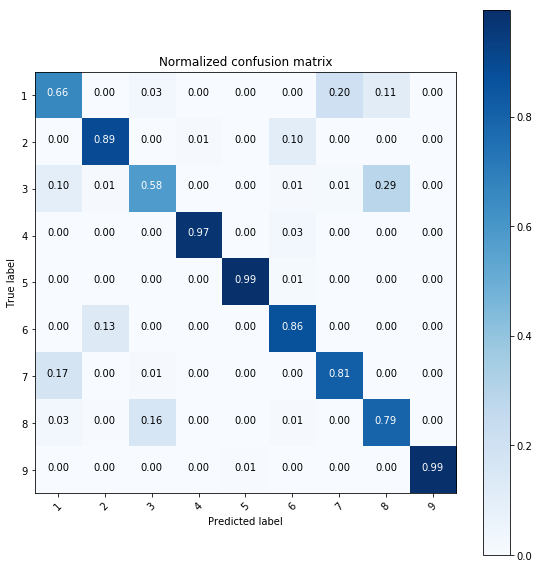

In [26]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

gnb_classifier = GaussianNB(var_smoothing=1e-20)
# A task
gnb_scores = cross_val_score(gnb_classifier,X_train_pca, y_train.ravel() ,cv=10, scoring='f1_micro')
gnb_std = np.std(gnb_scores)
print("The mean f1-micro score with a 10-fold Cross Validation is:",round(np.mean(gnb_scores),3))
print("The standard deviation of f1-micro score with a 10-fold Cross Validation is:",round(gnb_std,3))
print('---------------------------------------------------------------------------')
# B task
gnb_model = gnb_classifier.fit(X_train_pca, y_train.ravel())

class_names = [ 1, 2, 3, 4, 5, 6, 7, 8, 9]

preds = gnb_model.predict(X_test_pca)

cnf_matrix = confusion_matrix(y_test, preds, labels = class_names)

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
'''plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
'''
# Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')

print_classification_metrics(y_test, preds)

2. Naive Bayes

The mean f1-micro score with a 10-fold Cross Validation is: 0.645
The standard deviation of f1-micro score with a 10-fold Cross Validation is: 0.057
---------------------------------------------------------------------------
Normalized confusion matrix
 
[[0.5  0.   0.14 0.   0.   0.   0.31 0.05 0.  ]
 [0.   0.92 0.01 0.02 0.   0.05 0.   0.   0.  ]
 [0.05 0.   0.24 0.   0.   0.02 0.13 0.56 0.  ]
 [0.   0.   0.   0.99 0.01 0.01 0.   0.   0.  ]
 [0.   0.   0.01 0.   0.99 0.01 0.   0.   0.  ]
 [0.   0.41 0.   0.07 0.04 0.48 0.   0.   0.  ]
 [0.06 0.   0.08 0.   0.   0.   0.86 0.   0.  ]
 [0.   0.   0.15 0.   0.   0.   0.   0.84 0.  ]
 [0.   0.   0.   0.01 0.   0.   0.   0.   0.99]]

test accuracy_score: 0.6601

test f1-score: 0.6601

test precision score 0.6601

test recall score 0.6601

              precision    recall  f1-score   support

           1       0.74      0.50      0.60       261
           2       0.51      0.92      0.66       353
           3       0.48      0.24      0.

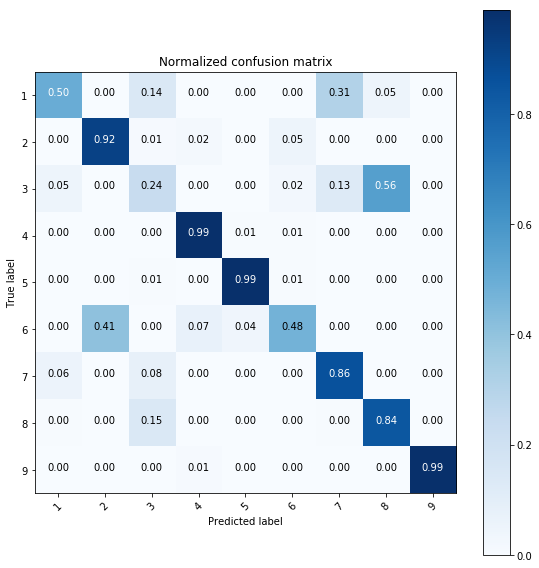

In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

gnb_classifier = GaussianNB()
# A task
gnb_scores = cross_val_score(gnb_classifier,X_train, y_train ,cv=10)
gnb_std = np.std(gnb_scores)
print("The mean f1-micro score with a 10-fold Cross Validation is:",round(np.mean(gnb_scores),3))
print("The standard deviation of f1-micro score with a 10-fold Cross Validation is:",round(gnb_std,3))
print('---------------------------------------------------------------------------')
# B task
gnb_model = gnb_classifier.fit(X_train, y_train)

class_names = [ 1, 2, 3, 4, 5, 6, 7, 8, 9]

preds = gnb_model.predict(X_test)

cnf_matrix = confusion_matrix(y_test, preds, labels = class_names)

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
'''plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
'''
# Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')

print_classification_metrics(y_test, preds)

### (b) Minimun Euclidean distance

In [28]:
def create_index(classes, category, y):
    '''
    Locate samples belonging to each category
    
    '''
    from collections import defaultdict
    #index = {}
    index = defaultdict(list)
    
    for i in range(classes):
        
        index[i+1] = (y==i+1).reshape(len(y))
               
        
    return index[category]

In [29]:
def mean_of_category(X_train, classes, category, y):
    
    '''
    Returns the mean of each category among  (1,2,3,4,5,6,7,8,9) for every dimension (103 spectral dimension)
      
    '''
    from collections import defaultdict
    
    mean = defaultdict(list)
    #mean = {}
    for i in range(classes):
        mean[i+1] = np.mean(X_train[create_index(classes, category, y),:], 0)
        
    return mean[category]

#### Implement 10 fold cross validation for Minimum Euclidean Distance Classifier

In [30]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

X=X_train
y=y_train

kf = KFold(n_splits=10,shuffle=True)
acc = []
print(kf)
print()
count=0

for train_index, test_index in kf.split(X):
    count +=1
    min_pos = [] 
    
    XX_train, XX_test = X[train_index], X[test_index]
    yy_train, yy_test = y[train_index], y[test_index]
    
    dist_all_arrays = np.zeros((len(XX_test),9))   
    mean_all = []         
       
    for i in range(9):
        
        mean_all.append(mean_of_category(XX_train, 9, i+1, yy_train))            
        
        for j in range(len(XX_test)):
            
            dist_all_arrays[j,i] = np.linalg.norm(mean_all[i] - XX_test[j,:])
                      
    y_pred = np.argmin(dist_all_arrays,axis=1) + 1 # min distance across classes
    acc.append(100*accuracy_score(y_pred, yy_test))
    print('Cross Validation:',count)
    print("Accuracy:",round(100*accuracy_score(y_pred, yy_test),3),'%')
    print('---------------------------')
print('The mean accuracy for a 10 fold cross validation is:',round(np.mean(acc),4),'%')
print('The stamdard deviation of a 10 fold cross validation is:',round(np.std(acc)/100,4))

KFold(n_splits=10, random_state=None, shuffle=True)

Cross Validation: 1
Accuracy: 56.231 %
---------------------------
Cross Validation: 2
Accuracy: 52.181 %
---------------------------
Cross Validation: 3
Accuracy: 58.1 %
---------------------------
Cross Validation: 4
Accuracy: 56.698 %
---------------------------
Cross Validation: 5
Accuracy: 60.903 %
---------------------------
Cross Validation: 6
Accuracy: 57.566 %
---------------------------
Cross Validation: 7
Accuracy: 56.474 %
---------------------------
Cross Validation: 8
Accuracy: 54.758 %
---------------------------
Cross Validation: 9
Accuracy: 57.098 %
---------------------------
Cross Validation: 10
Accuracy: 57.098 %
---------------------------
The mean accuracy for a 10 fold cross validation is: 56.7107 %
The stamdard deviation of a 10 fold cross validation is: 0.0213


In [ ]:
# Train on the whole dataset for Euclidean minimum distance

dist_all_arrays = np.zeros((len(X_test),9))   
mean_all = []         
       
for i in range(9):
        
    mean_all.append(mean_of_category(X_train, 9, i+1, y_train))            
        
    for j in range(len(X_test)):
            
        dist_all_arrays[j,i] = np.linalg.norm(mean_all[i] - X_test[j,:])
                      
y_pred = np.argmin(dist_all_arrays,axis=1) + 1 # min distance across classes

from sklearn.metrics import confusion_matrix

class_names = [1,2,3,4,5,6,7,8,9]

cnf_matrix = confusion_matrix(y_test, y_pred, labels = class_names)

np.set_printoptions(precision=2)
'''plt.figure(figsize=(8,8))

plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
'''
# Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')

print_classification_metrics(y_test,y_pred)

### (c) KNN

####  Cross validation for optimal neighbors (OPTIONAL)

The optimal number of neighbors is 9


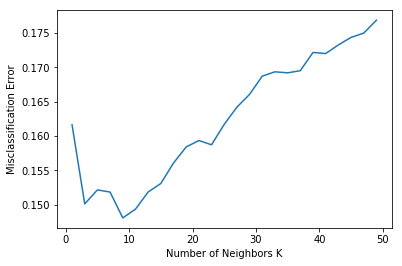

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

myList = list(range(1,50))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))


# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
error = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[error.index(min(error))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

The mean f1-micro score with a 10-fold Cross Validation is: 0.848
The standard deviation of f1-micro score with a 10-fold Cross Validation is: 0.054
------------------------------------------------------------------------------
Normalized confusion matrix
 
[[0.75 0.   0.06 0.   0.   0.   0.09 0.1  0.  ]
 [0.   0.91 0.   0.   0.   0.09 0.   0.   0.  ]
 [0.02 0.   0.84 0.   0.   0.01 0.   0.13 0.  ]
 [0.   0.   0.   0.99 0.   0.01 0.   0.   0.  ]
 [0.   0.   0.01 0.   0.99 0.   0.   0.01 0.  ]
 [0.   0.07 0.   0.   0.   0.92 0.   0.   0.  ]
 [0.04 0.   0.02 0.   0.   0.   0.94 0.   0.  ]
 [0.02 0.   0.18 0.   0.   0.   0.   0.79 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]

test accuracy_score: 0.8865

test f1-score: 0.8865

test precision score 0.8865

test recall score 0.8865

              precision    recall  f1-score   support

           1       0.86      0.75      0.80       261
           2       0.85      0.91      0.88       353
           3       0.81      0.84     

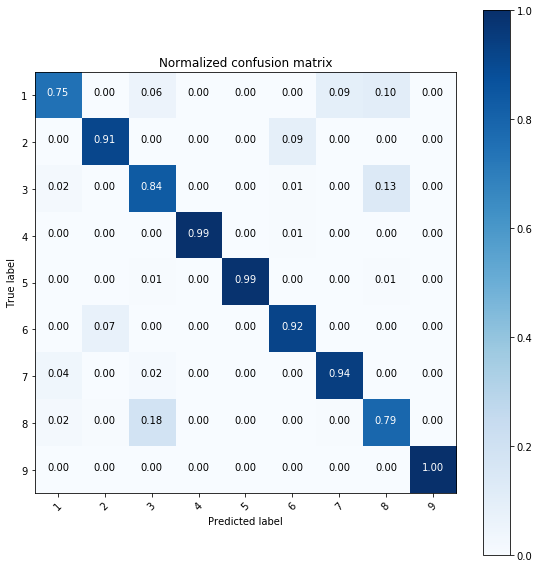

In [32]:
from sklearn.metrics import confusion_matrix

clf = KNeighborsClassifier(n_neighbors = 5)
clf_scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_micro')
clf_std = np.std(clf_scores)

print("The mean f1-micro score with a 10-fold Cross Validation is:",round(np.mean(clf_scores),3))
print("The standard deviation of f1-micro score with a 10-fold Cross Validation is:",round(clf_std,3))
print('------------------------------------------------------------------------------')
# B task
clf_model = clf.fit(X_train, y_train)
preds = clf_model.predict(X_test)
class_names=[1,2,3,4,5,6,7,8,9]

cnf_matrix = confusion_matrix(y_test, preds, labels = class_names)

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
#plt.figure()
'''plt.figure(figsize=(8,8))

plot_confusion_matrix(cnf_matrix, classes=class_names, itle='Confusion matrix, without normalization')
'''
# Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')

print_classification_metrics(y_test,preds)

### KNN with p=1 [ equivalent to using manhattan distance] (OPTIONAL)

The mean f1-micro score with a 10-fold Cross Validation is: 0.859
The standard deviation of f1-micro score with a 10-fold Cross Validation is: 0.053
-----------------------------------------------------------------------------------
Normalized confusion matrix
 
[[0.76 0.   0.05 0.   0.   0.   0.09 0.1  0.  ]
 [0.   0.91 0.   0.   0.   0.08 0.   0.   0.  ]
 [0.02 0.   0.86 0.   0.   0.01 0.   0.11 0.  ]
 [0.   0.   0.   0.99 0.   0.01 0.   0.   0.  ]
 [0.   0.   0.01 0.   0.99 0.   0.   0.01 0.  ]
 [0.   0.08 0.   0.   0.   0.92 0.   0.   0.  ]
 [0.03 0.   0.02 0.   0.   0.   0.95 0.   0.  ]
 [0.02 0.   0.19 0.   0.   0.   0.   0.79 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]

test accuracy_score: 0.8906

test f1-score: 0.8906

test precision score 0.8906

test recall score 0.8906

              precision    recall  f1-score   support

           1       0.88      0.76      0.82       261
           2       0.84      0.91      0.87       353
           3       0.81      0.86

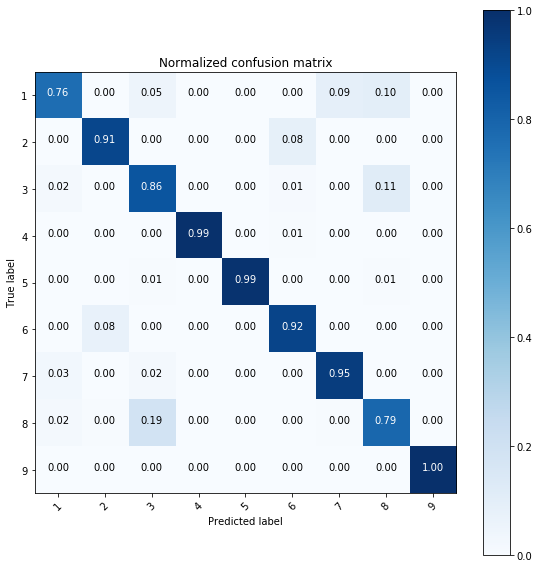

In [33]:
clf = KNeighborsClassifier(5, p=1)

# A task
clf_scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_micro')
clf_std = np.std(clf_scores)

print("The mean f1-micro score with a 10-fold Cross Validation is:",round(np.mean(clf_scores),3))
print("The standard deviation of f1-micro score with a 10-fold Cross Validation is:",round(clf_std,3))
print('-----------------------------------------------------------------------------------')
# B task
clf_model = clf.fit(X_train, y_train)
preds = clf_model.predict(X_test)
class_names=[1,2,3,4,5,6,7,8,9]

cnf_matrix = confusion_matrix(y_test, preds, labels = class_names)

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
#plt.figure()
'''plt.figure(figsize=(8,8))

plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
'''
# Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')

print_classification_metrics(y_test,preds)

### (d) Bayesian Classifier

In [34]:
import pandas as pd
from scipy.stats import multivariate_normal

In [35]:
def create_index(classes, category, y):
    '''
    Locate samples belonging to each category
    
    '''
    index = {}
    
    for i in range(classes):
        
        index[i+1] = (y==i+1).reshape(len(y))
               
        
    return index[category]

In [36]:
def count_number_of_samples(classes,category, y):
    
    N={}
    
    for i in range(classes):
        create_index(classes, category,y)
        N[i+1] = np.count_nonzero(create_index(classes, category,y))
    return N[category]

In [37]:
# Compute probabilities of each class (a priori)
N = np.count_nonzero(Training_Set)

P1 = count_number_of_samples(9,1,y_train)/N
P2 = count_number_of_samples(9,2,y_train)/N
P3 = count_number_of_samples(9,3,y_train)/N
P4 = count_number_of_samples(9,4,y_train)/N
P5 = count_number_of_samples(9,5,y_train)/N
P6 = count_number_of_samples(9,6,y_train)/N
P7 = count_number_of_samples(9,7,y_train)/N
P8 = count_number_of_samples(9,8,y_train)/N
P9 = count_number_of_samples(9,9,y_train)/N


name1 = ["$P_{\omega_1}$","$P_{\omega_2}$","$P_{\omega_3}$","$P_{\omega_4}$","$P_{\omega_5}$","$P_{\omega_6}$","$P_{\omega_7}$","$P_{\omega_8}$","$P_{\omega_9}$"]
pd.DataFrame([P1,P2,P3,P4,P5,P6,P7,P8,P9],name1,[""])

,
$P_{\omega_1}$,0.089634
$P_{\omega_2}$,0.108807
$P_{\omega_3}$,0.157911
$P_{\omega_4}$,0.046142
$P_{\omega_5}$,0.055963
$P_{\omega_6}$,0.235698
$P_{\omega_7}$,0.105690
$P_{\omega_8}$,0.138581
$P_{\omega_9}$,0.061574


In [64]:
def mean_of_category(x_train, classes, category, y):
    
    '''
    Returns the mean of each category among  (1,2,3,4,5,6,7,8,9) for every dimension (103 spectral dimension)
      
    '''
    mean = {}
    for i in range(classes):
        mean[i+1] = np.mean(x_train[create_index(classes, category, y),:], 0)
        
    return mean[category]

In [65]:
def cov_matrix_of_category(x_train, classes, category,y):
    
    '''
    Returns the covariance matrix of each category among  (1,2,3,4,5,6,7,8,9) (dimensions 103x103)
    
    '''
    S={} # dict of cov matrices
    import numpy.matlib as nm
    for i in range(classes):
        
        indx = create_index(classes, category, y)
        N = count_number_of_samples(classes,category, y)
        m = mean_of_category(x_train, classes, category, y)
        
      
        S[i+1] =  1/N*((x_train[indx,:] - nm.repmat(m,N,1)).T).dot((x_train[indx,:] - nm.repmat(m,N,1)))
        
    return S[category]

In [70]:
def create_pdfs(x_train, x_test, classes, category, y):
    
    
    classes_scores = {}
    P = [P1,P2,P3,P4,P5,P6,P7,P8,P9]
    for i in range(classes):
        
        m = mean_of_category(x_train, classes, category, y)
        S = cov_matrix_of_category(x_train, classes, category,y)
        
        classes_scores[i+1] = multivariate_normal(m,S).pdf(x_test)*P[i]
    
    return classes_scores[category]

### 10 Fold cross validation for bayes classifier

In [73]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

X=X_train
y=y_train

kf = KFold(n_splits=10,shuffle=True)
acc = []
print(kf)
print()
count=0

for train_index, test_index in kf.split(X):
    count +=1
    min_pos = [] 
    
    XX_train, XX_test = X[train_index], X[test_index]
    yy_train, yy_test = y[train_index], y[test_index]
            
    scores = np.array([create_pdfs(XX_train,XX_test, 9, 1,yy_train),create_pdfs(XX_train,XX_test, 9, 2,yy_train),
                   create_pdfs(XX_train,XX_test, 9, 3,yy_train),create_pdfs(XX_train,XX_test, 9, 4,yy_train),
                   create_pdfs(XX_train,XX_test, 9, 5,yy_train),create_pdfs(XX_train,XX_test, 9, 6,yy_train),
                   create_pdfs(XX_train,XX_test, 9, 7,yy_train),create_pdfs(XX_train,XX_test, 9, 8,yy_train),
                   create_pdfs(XX_train,XX_test, 9, 9,yy_train)]).T
    Btest_y = np.argmax(scores,axis=1).reshape(len(scores),1) + 1  
    
    acc.append(100*accuracy_score(Btest_y, yy_test))
    print('Cross Validation:',count)
    print("Accuracy:",round(100*accuracy_score(Btest_y, yy_test),3),'%')
    print('---------------------------')
print('The mean accuracy for a 10 fold cross validation is:',round(np.mean(acc),4),'%')
print('The standard deviation of a 10 fold cross validation is:',round(np.std(acc)/100,4))

KFold(n_splits=10, random_state=None, shuffle=True)

Cross Validation: 1
Accuracy: 87.85 %
---------------------------
Cross Validation: 2
Accuracy: 87.227 %
---------------------------
Cross Validation: 3
Accuracy: 88.941 %
---------------------------
Cross Validation: 4
Accuracy: 86.76 %
---------------------------
Cross Validation: 5
Accuracy: 90.187 %
---------------------------
Cross Validation: 6
Accuracy: 88.768 %
---------------------------
Cross Validation: 7
Accuracy: 89.08 %
---------------------------
Cross Validation: 8
Accuracy: 88.612 %
---------------------------
Cross Validation: 9
Accuracy: 86.115 %
---------------------------
Cross Validation: 10
Accuracy: 87.363 %
---------------------------
The mean accuracy for a 10 fold cross validation is: 88.0903 %
The stamdard deviation of a 10 fold cross validation is: 0.0118


Normalized confusion matrix
 
[[0.59 0.   0.18 0.   0.   0.01 0.04 0.18 0.  ]
 [0.   0.93 0.   0.01 0.   0.06 0.   0.   0.  ]
 [0.02 0.   0.8  0.   0.   0.   0.   0.18 0.  ]
 [0.   0.   0.   0.99 0.   0.01 0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.04 0.   0.03 0.   0.   0.01 0.91 0.01 0.  ]
 [0.04 0.   0.16 0.   0.   0.   0.   0.8  0.  ]
 [0.02 0.   0.   0.01 0.01 0.   0.   0.   0.97]]

test accuracy_score: 0.8843

test f1-score: 0.8843

test precision score 0.8843

test recall score 0.8843

              precision    recall  f1-score   support

           1       0.77      0.59      0.67       261
           2       0.99      0.93      0.96       353
           3       0.77      0.80      0.79       536
           4       0.97      0.99      0.98       156
           5       0.99      1.00      0.99       168
           6       0.96      1.00      0.98       764
           7       0.97      0.91      0.94       

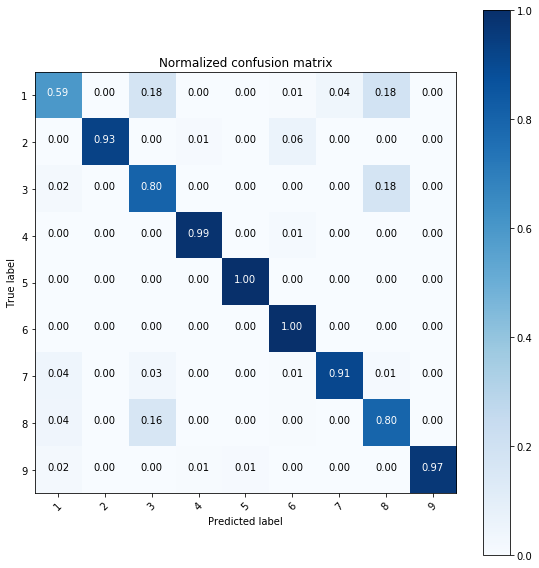

In [75]:
scores = np.array([create_pdfs(X_train, X_test, 9, 1,y_train),create_pdfs(X_train,X_test, 9, 2,y_train),
                   create_pdfs(X_train,X_test, 9, 3,y_train),create_pdfs(X_train,X_test, 9, 4,y_train),
                   create_pdfs(X_train,X_test, 9, 5,y_train),create_pdfs(X_train,X_test, 9, 6,y_train),
                   create_pdfs(X_train,X_test, 9, 7,y_train),create_pdfs(X_train,X_test, 9, 8,y_train),
                   create_pdfs(X_train,X_test, 9, 9,y_train)]).T

Btest_y = np.argmax(scores,axis=1).reshape(len(scores),1) + 1

cnf_matrix = confusion_matrix(y_test, Btest_y, labels = class_names)

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
#plt.figure()
'''plt.figure(figsize=(8,8))

plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')'''

# Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')

print_classification_metrics(y_test, Btest_y)

# Optional Plots

## Learning Curves for classifiers (Naive Bayes, KNN)

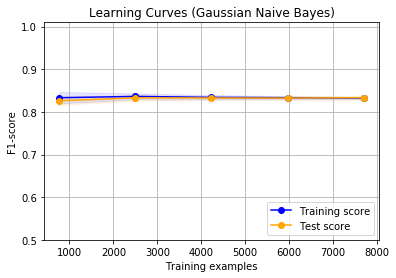

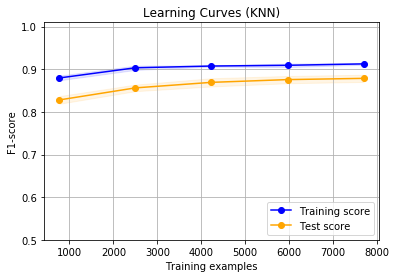

In [43]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1-score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,scoring='f1_micro', train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange",
             label="Test score")

    plt.legend(loc="lower right")
    return plt

X = np.concatenate([X_train_pca,X_test_pca],axis=0)
y = np.concatenate([y_train,y_test],axis=0)

#X, y = X_train_pca,y_train

title = "Learning Curves (Gaussian Naive Bayes)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.5, 1.01), cv=cv, n_jobs=2)
plt.show()

title = "Learning Curves (KNN)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = KNeighborsClassifier(5)
plot_learning_curve(estimator, title, X, y, (0.5, 1.01), cv=cv, n_jobs=2)
plt.show()

## AUC and ROC
If we want to compare our classifiers in a graphical way we can sum up to the below AUC plot

In [44]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.model_selection import train_test_split

# Binarize the output
label = np.concatenate([y_train,y_test],axis=0)
image = np.concatenate([X_train,X_test],axis=0)

label = label_binarize(label, classes=[1,2,3,4,5,6,7,8,9])
n_classes = label.shape[1]

X_train, X_test, y_train, y_test = train_test_split(image, label, test_size = 0.5, random_state=489)

In [45]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(GaussianNB())

y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [46]:
# Learn to predict each class against the other
classifier_knn = OneVsRestClassifier(KNeighborsClassifier(9))

y_score_knn = classifier_knn.fit(X_train, y_train).predict_proba(X_test)
# Compute ROC curve and ROC area for each class
fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()
for i in range(n_classes):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test[:, i], y_score_knn[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])

# Compute micro-average ROC curve and ROC area
fpr_knn["micro"], tpr_knn["micro"], _ = roc_curve(y_test.ravel(), y_score_knn.ravel())
roc_auc_knn["micro"] = auc(fpr_knn["micro"], tpr_knn["micro"])

## Compare Naive Bayes and KNN for every class with ROC curves

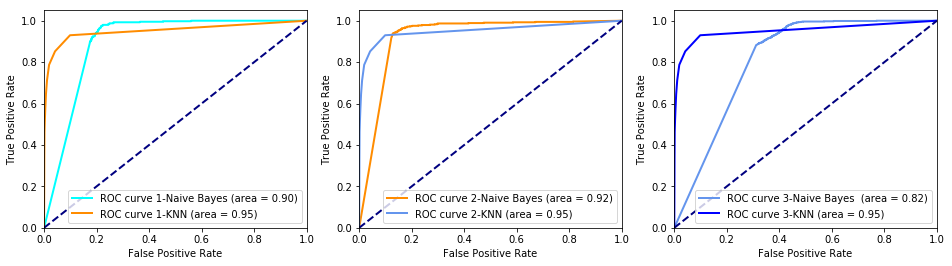

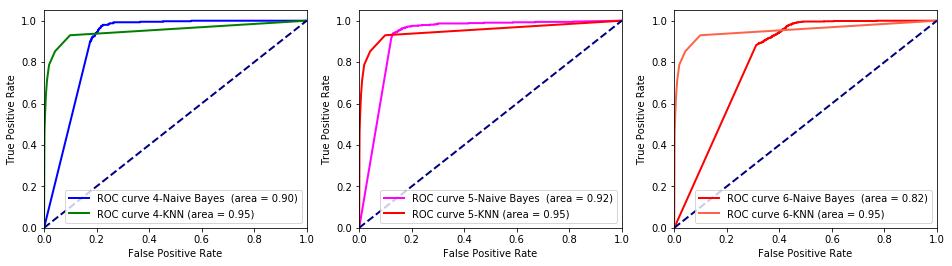

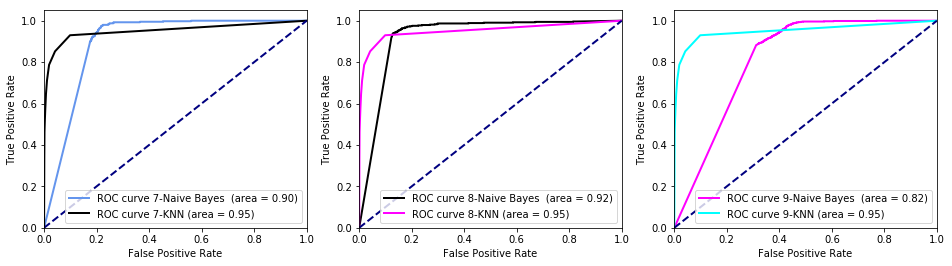

In [47]:
#Plot of a ROC curve for a specific class
color_list = ['aqua', 'darkorange', 'cornflowerblue','blue','green','red','tomato','black','magenta']
fig, ax = plt.subplots(4,4,figsize=(16,4))
lw = 2

ax1 = plt.subplot(131)
ax1.plot(fpr[0], tpr[0], color=color_list[0], lw=lw, label='ROC curve 1-Naive Bayes (area = %0.2f)' % roc_auc[0])
ax1.plot(fpr_knn[0], tpr_knn[0], color=color_list[1], lw=lw, label='ROC curve 1-KNN (area = %0.2f)' % roc_auc_knn[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

ax2 = plt.subplot(132)
ax2.plot(fpr[1], tpr[1], color=color_list[1], lw=lw, label='ROC curve 2-Naive Bayes (area = %0.2f)' % roc_auc[1])
ax2.plot(fpr_knn[0], tpr_knn[0], color=color_list[2], lw=lw, label='ROC curve 2-KNN (area = %0.2f)' % roc_auc_knn[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

ax3 = plt.subplot(133)
ax3.plot(fpr[2], tpr[2], color=color_list[2], lw=lw, label='ROC curve 3-Naive Bayes  (area = %0.2f)' % roc_auc[2])
ax3.plot(fpr_knn[0], tpr_knn[0], color=color_list[3], lw=lw, label='ROC curve 3-KNN (area = %0.2f)' % roc_auc_knn[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

fig, ax = plt.subplots(4,4,figsize=(16,4))
lw = 2
ax4 = plt.subplot(131)
ax4.plot(fpr[0], tpr[0], color=color_list[3], lw=lw, label='ROC curve 4-Naive Bayes  (area = %0.2f)' % roc_auc[0])
ax4.plot(fpr_knn[0], tpr_knn[0], color=color_list[4], lw=lw, label='ROC curve 4-KNN (area = %0.2f)' % roc_auc_knn[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

ax5 = plt.subplot(132)
ax5.plot(fpr[1], tpr[1], color=color_list[8], lw=lw, label='ROC curve 5-Naive Bayes  (area = %0.2f)' % roc_auc[1])
ax5.plot(fpr_knn[0], tpr_knn[0], color=color_list[5], lw=lw, label='ROC curve 5-KNN (area = %0.2f)' % roc_auc_knn[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

ax6 = plt.subplot(133)
ax6.plot(fpr[2], tpr[2], color=color_list[5], lw=lw, label='ROC curve 6-Naive Bayes  (area = %0.2f)' % roc_auc[2])
ax6.plot(fpr_knn[0], tpr_knn[0], color=color_list[6], lw=lw, label='ROC curve 6-KNN (area = %0.2f)' % roc_auc_knn[0])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

fig, ax = plt.subplots(4,4,figsize=(16,4))
lw = 2

ax7 = plt.subplot(131)
ax7.plot(fpr[0], tpr[0], color=color_list[2], lw=lw, label='ROC curve 7-Naive Bayes  (area = %0.2f)' % roc_auc[0])
ax7.plot(fpr_knn[0], tpr_knn[0], color=color_list[7], lw=lw, label='ROC curve 7-KNN (area = %0.2f)' % roc_auc_knn[0])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

ax8 = plt.subplot(132)
ax8.plot(fpr[1], tpr[1], color=color_list[7], lw=lw, label='ROC curve 8-Naive Bayes  (area = %0.2f)' % roc_auc[1])
ax8.plot(fpr_knn[0], tpr_knn[0], color=color_list[8], lw=lw, label='ROC curve 8-KNN (area = %0.2f)' % roc_auc_knn[0])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

ax9 = plt.subplot(133)
ax9.plot(fpr[2], tpr[2], color=color_list[8], lw=lw, label='ROC curve 9-Naive Bayes  (area = %0.2f)' % roc_auc[2])
ax9.plot(fpr_knn[0], tpr_knn[0], color=color_list[0], lw=lw, label='ROC curve 9-KNN (area = %0.2f)' % roc_auc_knn[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

## Compare for KNN Classifier the scores among the classes

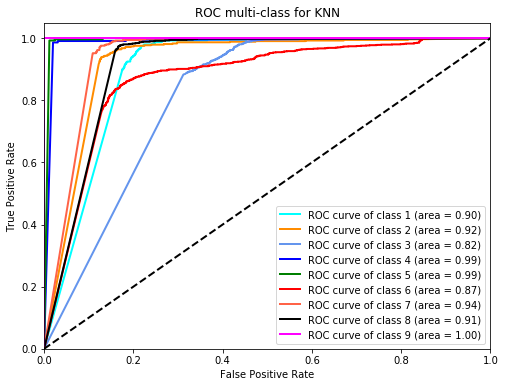

In [48]:
# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,6))
'''plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
'''
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','blue','green','red','tomato','black','magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC multi-class for KNN')
plt.legend(loc="lower right")
plt.show()